In [1]:
from jaad_data import JAAD

# Path to JAAD root folder
jaad_path = "F:\models\JAAD"   # folder containing JAAD/data_cache, annotations, JAAD_clips, etc.

# # jaad = JAAD(jaad_path)
# # jaad.extract_and_save_images()
jaad = JAAD("F:/models/JAAD", regen_pkl=False)
# database = jaad.generate_database()

train = jaad.generate_data_trajectory_sequence(
    'train',
    seq_type='crossing',
    sample_type='beh'
)

val = jaad.generate_data_trajectory_sequence(
    'val',
    seq_type='crossing',
    sample_type='beh'
)

test = jaad.generate_data_trajectory_sequence(
    'test',
    seq_type='crossing',
    sample_type='beh'
)


print(len(train['image']))
print(train['image'][0])
print(train['intent'][0])
print(train['bbox'][0])



<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_24248\2431003295.py:4: SyntaxWarning: invalid escape sequence '\m'
  jaad_path = "F:\models\JAAD"   # folder containing JAAD/data_cache, annotations, JAAD_clips, etc.
C:\Users\Mac Planet\AppData\Local\Temp\ipykernel_24248\2431003295.py:4: SyntaxWarning: invalid escape sequence '\m'
  jaad_path = "F:\models\JAAD"   # folder containing JAAD/data_cache, annotations, JAAD_clips, etc.


ModuleNotFoundError: No module named 'jaad_data'

In [58]:
print(train.keys())

dict_keys(['image', 'pid', 'bbox', 'center', 'occlusion', 'vehicle_act', 'intent', 'activities', 'image_dimension'])


In [59]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class JAADDataset(Dataset):
    def __init__(self, data_dict, seq_len=15, img_size=224):
        """
        data_dict : JAAD split (train/val/test)
        seq_len   : fixed sequence length for GRU
        img_size  : cropped pedestrian image size
        """

        self.images = data_dict['image']          # list of sequences of image paths
        self.bboxes = data_dict['bbox']           # list of sequences of bbox coords
        self.centers = data_dict['center']        # list of sequences of (x_center, y_center)
        self.vehicle_act = data_dict['vehicle_act']  # vehicle state per frame
        self.labels = [int(x[0][0]) for x in data_dict['intent']]  # sequence label (0/1)

        # sequence length
        self.seq_len = seq_len

        # image transformation
        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

        # used to normalize bbox and center
        self.img_w, self.img_h = data_dict['image_dimension']

    def __len__(self):
        return len(self.images)

    def pad_sequence(self, *seq_lists):
        """
        Pads or trims sequences so all have seq_len elements.
        """
        padded = []
        for seq in seq_lists:
            s = list(seq)
            while len(s) < self.seq_len:
                s.append(s[-1])    # repeat last frame
            padded.append(s[:self.seq_len])
        return padded

    def __getitem__(self, idx):
        # original sequences
        imgs = self.images[idx]
        bboxes = self.bboxes[idx]
        centers = self.centers[idx]
        veh = self.vehicle_act[idx]
        label = self.labels[idx]

        # pad or cut sequences
        imgs, bboxes, centers, veh = self.pad_sequence(
            imgs, bboxes, centers, veh
        )

        # ----------------------------------------------------
        # 1) IMAGE SEQUENCE (cropped pedestrian images)
        # ----------------------------------------------------
        frame_tensors = []
        for img_path, box in zip(imgs, bboxes):
            img = Image.open(img_path).convert("RGB")
            img = img.crop((box[0], box[1], box[2], box[3]))
            img = self.transform(img)
            frame_tensors.append(img)

        # shape = (T, 3, H, W)
        frames = torch.stack(frame_tensors)

        # ----------------------------------------------------
        # 2) EXTRA FEATURES PER FRAME
        # ----------------------------------------------------
        features = []
        for c, b, v in zip(centers, bboxes, veh):

            # center normalized
            cx = c[0] / self.img_w
            cy = c[1] / self.img_h

            # bbox size normalized
            bw = (b[2] - b[0]) / self.img_w
            bh = (b[3] - b[1]) / self.img_h

            # FIX → vehicle_act is inside a list like [0]
            veh_val = v[0] if isinstance(v, list) else v

            features.append([cx, cy, bw, bh, float(veh_val)])

        # shape = (T, 5)
        extra = torch.tensor(features, dtype=torch.float32)

        # ----------------------------------------------------
        # return everything
        # ----------------------------------------------------
        return frames, extra, torch.tensor(label, dtype=torch.float32)


In [60]:
train_dataset = JAADDataset(train, seq_len=15)
val_dataset   = JAADDataset(val, seq_len=15)
test_dataset  = JAADDataset(test, seq_len=15)


In [61]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,   # put >0 only if NOT using Jupyter/Windows
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


Label: 0
Extra features (first frames):
tensor([[0.7510, 0.7157, 0.0458, 0.2204, 1.0000]])


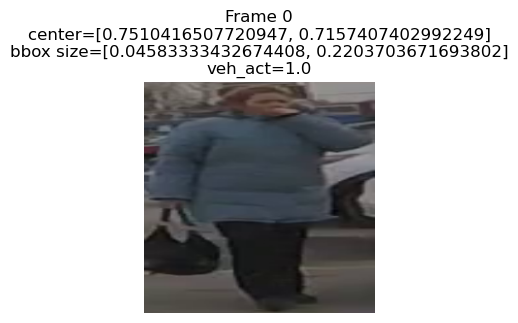

In [62]:
import matplotlib.pyplot as plt

def show_sequence(dataset, index=0, num_frames=6):
    frames, extra, label = dataset[index]

    print("Label:", int(label.item()))
    print("Extra features (first frames):")
    print(extra[:num_frames])

    for i in range(num_frames):
        img = frames[i].permute(1,2,0)  # Tensor CHW → HWC

        plt.figure(figsize=(3,3))
        plt.imshow(img)
        plt.title(
            f"Frame {i}\n"
            f"center={extra[i][:2].tolist()}\n"
            f"bbox size={extra[i][2:4].tolist()}\n"
            f"veh_act={extra[i][4].item()}"
        )
        plt.axis("off")
        plt.show()

show_sequence(train_dataset, index=0, num_frames=1)


In [63]:
import torch
import torch.nn as nn
import torchvision.models as models

class PedestrianIntentModel(nn.Module):
    def __init__(
        self,
        cnn_backbone: str = "resnet18",
        cnn_pretrained: bool = False,
        extra_feat_dim: int = 5,   # [cx, cy, bw, bh, vehicle_act]
        gru_hidden_dim: int = 128,
        gru_num_layers: int = 1,
        dropout: float = 0.3
    ):
        super().__init__()

        # -------------------------
        # 1) CNN backbone
        # -------------------------
        if cnn_backbone == "resnet18":
            self.cnn = models.resnet18(pretrained=cnn_pretrained)
            cnn_feat_dim = self.cnn.fc.in_features
            self.cnn.fc = nn.Identity()  # remove final classifier
        elif cnn_backbone == "alexnet":
            self.cnn = models.alexnet(pretrained=cnn_pretrained)
            # flatten output of AlexNet classifier input
            cnn_feat_dim = self.cnn.classifier[1].in_features
            # keep only feature extractor part
            self.cnn.classifier = nn.Sequential(
                nn.Flatten(),
                # you could add your own linear layer here if you want
            )
        else:
            raise ValueError(f"Unsupported backbone: {cnn_backbone}")

        self.cnn_feat_dim = cnn_feat_dim

        # -------------------------
        # 2) GRU over time
        #    input = CNN features + extra features
        # -------------------------
        self.gru_input_dim = cnn_feat_dim + extra_feat_dim

        self.gru = nn.GRU(
            input_size=self.gru_input_dim,
            hidden_size=gru_hidden_dim,
            num_layers=gru_num_layers,
            batch_first=True,
            bidirectional=False
        )

        # -------------------------
        # 3) Classification head
        # -------------------------
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(gru_hidden_dim, gru_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(gru_hidden_dim, 1)  # binary classification
        )

    def forward(self, frames, extra):
        """
        frames: (B, T, 3, H, W)
        extra:  (B, T, 5)
        returns: logits of shape (B, 1)
                 (use BCEWithLogitsLoss)
        """
        B, T, C, H, W = frames.shape

        # -------------------------
        # CNN: process each frame
        # -------------------------
        # (B, T, C, H, W) -> (B*T, C, H, W)
        frames_flat = frames.view(B * T, C, H, W)

        cnn_feats = self.cnn(frames_flat)              # (B*T, cnn_feat_dim)
        cnn_feats = cnn_feats.view(B, T, self.cnn_feat_dim)  # (B, T, cnn_feat_dim)

        # -------------------------
        # Concatenate with extra features
        # -------------------------
        # extra already (B, T, extra_feat_dim)
        gru_input = torch.cat([cnn_feats, extra], dim=-1)  # (B, T, cnn_feat_dim + extra_dim)

        # -------------------------
        # GRU
        # -------------------------
        gru_out, h_n = self.gru(gru_input)  # gru_out: (B, T, H), h_n: (num_layers, B, H)

        # use last hidden state (of last layer)
        last_hidden = h_n[-1]  # (B, H)

        # -------------------------
        # Classification head
        # -------------------------
        x = self.dropout(last_hidden)
        logits = self.fc(x)  # (B, 1)

        return logits  # apply sigmoid outside if you want probs


In [64]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device="cuda"):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

        # ------------------------------
        # TRAINING
        # ------------------------------
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc="Training", leave=False)

        for frames, extra, labels in pbar:
            frames = frames.to(device)
            extra = extra.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            logits = model(frames, extra).squeeze(1)   # (B,)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)

            # compute accuracy
            preds = (torch.sigmoid(logits) >= 0.5).long()
            train_correct += (preds == labels.long()).sum().item()
            train_total += labels.size(0)

            pbar.set_postfix({"loss": loss.item()})

        train_loss /= train_total
        train_acc = train_correct / train_total

        # ------------------------------
        # VALIDATION
        # ------------------------------
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for frames, extra, labels in tqdm(val_loader, desc="Validation", leave=False):
                frames = frames.to(device)
                extra = extra.to(device)
                labels = labels.to(device)

                logits = model(frames, extra).squeeze(1)
                loss = criterion(logits, labels)

                val_loss += loss.item() * labels.size(0)

                preds = (torch.sigmoid(logits) >= 0.5).long()
                val_correct += (preds == labels.long()).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # ------------------------------
        # SAVE BEST MODEL
        # ------------------------------
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_crossing_intent_model.pth")
            print("🔥 Saved new best model!")

    print("\nTraining complete!")
    print(f"Best validation accuracy: {best_val_acc:.4f}")


In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = PedestrianIntentModel(
    cnn_backbone="resnet18",
    cnn_pretrained=True
)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=3,
    lr=1e-4,
    device=device
)


cpu

===== Epoch 1/3 =====


Train Loss: 0.4632 | Train Acc: 0.8702
Val Loss:   0.4682 | Val Acc:   0.8333
🔥 Saved new best model!

===== Epoch 2/3 =====


Train Loss: 0.2966 | Train Acc: 0.8779
Val Loss:   0.4911 | Val Acc:   0.8333

===== Epoch 3/3 =====


Train Loss: 0.1909 | Train Acc: 0.9389
Val Loss:   0.6294 | Val Acc:   0.8333

Training complete!
Best validation accuracy: 0.8333


In [46]:
import torch
from tqdm import tqdm

def test_model(model, test_loader, device="cuda"):
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for frames, extra, labels in tqdm(test_loader, desc="Testing"):
            frames = frames.to(device)
            extra = extra.to(device)
            labels = labels.to(device)

            logits = model(frames, extra).squeeze(1)
            probs = torch.sigmoid(logits)

            preds = (probs >= 0.5).long()

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().long().tolist())

    return all_labels, all_preds


In [47]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_predictions(labels, preds):
    print("\n=== Confusion Matrix ===")
    print(confusion_matrix(labels, preds))

    print("\n=== Classification Report ===")
    print(classification_report(labels, preds, digits=4))


In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# load best model
model = PedestrianIntentModel()
model.load_state_dict(torch.load("best_crossing_intent_model.pth"))
model.eval()

# run test
labels, preds = test_model(model, test_loader, device=device)

# metrics
evaluate_predictions(labels, preds)


Testing: 100%|██████████| 60/60 [07:59<00:00,  8.00s/it]


=== Confusion Matrix ===
[[  0  57]
 [  0 183]]

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        57
           1     0.7625    1.0000    0.8652       183

    accuracy                         0.7625       240
   macro avg     0.3812    0.5000    0.4326       240
weighted avg     0.5814    0.7625    0.6598       240




e:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
import numpy as np
labels = np.array([d[2] for d in train_dataset])  # dataset returns (frames, extra, label)
count_0 = np.sum(labels == 0)
count_1 = np.sum(labels == 1)
print(count_0, count_1)


32 230


In [67]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# Extract labels from train_dataset
labels = np.array([train_dataset[i][2].item() for i in range(len(train_dataset))])

# Count samples
class_count_0 = 32
class_count_1 = 230

# Compute weights
weights = np.zeros_like(labels, dtype=float)
weights[labels == 0] = 1.0 / class_count_0
weights[labels == 1] = 1.0 / class_count_1

# Build sampler
sampler = WeightedRandomSampler(
    weights=weights,
    num_samples=len(labels),
    replacement=True
)

# Build train loader with sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    sampler=sampler,
    num_workers=0,
    pin_memory=True
)

print("Balanced sampler created!")


Balanced sampler created!


In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = PedestrianIntentModel(
    cnn_backbone="resnet18",
    cnn_pretrained=True
)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=3,
    lr=1e-4,
    device=device
)


cpu


e:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



===== Epoch 1/3 =====


Training:   0%|          | 0/66 [00:00<?, ?it/s]e:\anaconda\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 0.5894 | Train Acc: 0.7061
Val Loss:   0.6403 | Val Acc:   0.6000
🔥 Saved new best model!

===== Epoch 2/3 =====


Train Loss: 0.2841 | Train Acc: 0.9542
Val Loss:   0.4852 | Val Acc:   0.8000
🔥 Saved new best model!

===== Epoch 3/3 =====


Train Loss: 0.1378 | Train Acc: 0.9771
Val Loss:   0.5315 | Val Acc:   0.8333
🔥 Saved new best model!

Training complete!
Best validation accuracy: 0.8333


In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# load best model
model = PedestrianIntentModel()
model.load_state_dict(torch.load("best_crossing_intent_model.pth"))
model.eval()

# run test
labels, preds = test_model(model, test_loader, device=device)

# metrics
evaluate_predictions(labels, preds)


e:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing: 100%|██████████| 60/60 [09:51<00:00,  9.86s/it]



=== Confusion Matrix ===
[[  6  51]
 [  6 177]]

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.5000    0.1053    0.1739        57
           1     0.7763    0.9672    0.8613       183

    accuracy                         0.7625       240
   macro avg     0.6382    0.5362    0.5176       240
weighted avg     0.7107    0.7625    0.6981       240



In [95]:
train = jaad.generate_data_trajectory_sequence(
    'train',
    seq_type='intention',
    sample_type='all',
    fstride=5

)

val = jaad.generate_data_trajectory_sequence(
    'val',
    seq_type='intention',
    sample_type='all',
    fstride=5

)

test = jaad.generate_data_trajectory_sequence(
    'test',
    seq_type='intention',
    sample_type='all',
    fstride=5
)


print(len(train['image']))
print(train['image'][0])
print(train['intent'][0])
print(train['bbox'][0])


---------------------------------------------------------
Generating action sequence data
fstride: 5
sample_type: all
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5, 'fold': 1}
---------------------------------------------------------
Generating database for jaad
jaad database loaded from F:\models\JAAD\data_cache\jaad_database.pkl
---------------------------------------------------------
Generating intention data
Split: train
Number of pedestrians: 1355 
Total number of samples: 807 
---------------------------------------------------------
Generating action sequence data
fstride: 5
sample_type: all
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5

In [98]:
print(train.keys())

dict_keys(['image', 'pid', 'bbox', 'center', 'occlusion', 'intent'])


In [100]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class JAADDataset(Dataset):
    def __init__(self, data_dict, seq_len=15, img_size=224):
        """
        For seq_type='intention'
        JAAD gives: image, pid, bbox, center, occlusion, intent
        """

        self.images  = data_dict["image"]
        self.bboxes  = data_dict["bbox"]
        self.centers = data_dict["center"]
        self.labels  = [int(x[0][0]) for x in data_dict["intent"]]

        self.seq_len = seq_len

        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

        # WARNING: image_dimension does NOT exist in intention mode
        # So we normalize using actual frame size from bbox
        # (w = x2 - x1, h = y2 - y1)
        # No global width/height available.

    def __len__(self):
        return len(self.images)

    def pad(self, seq):
        """Pad sequence to fixed seq_len."""
        seq = list(seq)
        if len(seq) == 0:
            return [seq[0]] * self.seq_len
        while len(seq) < self.seq_len:
            seq.append(seq[-1])
        return seq[:self.seq_len]

    def __getitem__(self, idx):
        imgs    = self.pad(self.images[idx])
        bboxes  = self.pad(self.bboxes[idx])
        centers = self.pad(self.centers[idx])
        label   = self.labels[idx]

        frame_tensors = []
        extra_feats   = []

        for img_path, box, center in zip(imgs, bboxes, centers):

            # --------------------------
            # 1) Load and crop image
            # --------------------------
            img = Image.open(img_path).convert("RGB")
            x1, y1, x2, y2 = box
            img = img.crop((x1, y1, x2, y2))
            img = self.transform(img)
            frame_tensors.append(img)

            # --------------------------
            # 2) Frame-specific features
            # --------------------------
            cx, cy = center

            # Normalize using bbox size (local normalization)
            bw = (x2 - x1)
            bh = (y2 - y1)
            cx_rel = (cx - x1) / bw if bw > 0 else 0
            cy_rel = (cy - y1) / bh if bh > 0 else 0
            bw_rel = bw / 1920       # assume HD width
            bh_rel = bh / 1080       # assume HD height

            extra_feats.append([cx_rel, cy_rel, bw_rel, bh_rel])

        frames = torch.stack(frame_tensors)                  # (T, 3, H, W)
        extras = torch.tensor(extra_feats, dtype=torch.float32)  # (T, 4)

        return frames, extras, torch.tensor(label, dtype=torch.float32)


In [101]:
train_dataset = JAADDataset(train, seq_len=50)
val_dataset   = JAADDataset(val, seq_len=50)
test_dataset  = JAADDataset(test, seq_len=50)


In [102]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# Extract labels
train_labels = np.array([train_dataset[i][2].item() for i in range(len(train_dataset))])

count_0 = np.sum(train_labels == 0)
count_1 = np.sum(train_labels == 1)
print(count_0, count_1)

# Inverse frequency = larger weight for rare class (0)
weight_0 = 1.0 / count_0
weight_1 = 1.0 / count_1

sample_weights = np.array([weight_0 if l == 0 else weight_1 for l in train_labels])

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    sampler=sampler,
    num_workers=0,
    pin_memory=True
)

# val/test normal loaders
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


617 190


In [105]:
import torch
import torch.nn as nn

pos_weight = torch.tensor(count_1 / count_0)   # increases penalty for class 0 errors
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [106]:
import torch
from torch.optim import Adam
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device="cpu"):
    model.to(device)
    
    # class imbalance fixed here
    train_labels = np.array([train_dataset[i][2].item() for i in range(len(train_dataset))])
    count_0 = np.sum(train_labels == 0)
    count_1 = np.sum(train_labels == 1)
    pos_weight = torch.tensor(count_1 / count_0).to(device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

        # ---------------------
        # TRAIN MODE
        # ---------------------
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        for frames, extra, labels in tqdm(train_loader, desc="Training"):
            frames, extra, labels = frames.to(device), extra.to(device), labels.to(device)

            optimizer.zero_grad()

            logits = model(frames, extra).squeeze(1)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).long()
            total_correct += (preds == labels.long()).sum().item()
            total_samples += labels.size(0)

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples

        # ---------------------
        # VALIDATION MODE
        # ---------------------
        model.eval()
        val_loss, val_correct, val_samples = 0, 0, 0

        with torch.no_grad():
            for frames, extra, labels in tqdm(val_loader, desc="Validation"):
                frames, extra, labels = frames.to(device), extra.to(device), labels.to(device)

                logits = model(frames, extra).squeeze(1)
                loss = criterion(logits, labels)

                val_loss += loss.item() * labels.size(0)
                preds = (torch.sigmoid(logits) >= 0.5).long()
                val_correct += (preds == labels.long()).sum().item()
                val_samples += labels.size(0)

        val_loss /= val_samples
        val_acc = val_correct / val_samples

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # SAVE BEST MODEL
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_crossing_intent_model.pth")
            print("🔥 Saved new BEST model!")

    print("\nTraining finished!")
    print("Best Validation Accuracy:", best_val_acc)


In [107]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = PedestrianIntentModel(
    cnn_backbone="resnet18",
    cnn_pretrained=True,
    extra_feat_dim=4
)

train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=3,
    lr=1e-4,
    device=device
)


cpu


e:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



===== Epoch 1/3 =====


Training:   0%|          | 0/202 [00:00<?, ?it/s]e:\anaconda\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation: 100%|██████████| 31/31 [12:11<00:00, 23.61s/it]


Train Loss: 0.2585 | Train Acc: 0.7249
Val Loss:   0.1896 | Val Acc:   0.8347
🔥 Saved new BEST model!

===== Epoch 2/3 =====


Validation: 100%|██████████| 31/31 [11:02<00:00, 21.38s/it]


Train Loss: 0.1892 | Train Acc: 0.8315
Val Loss:   0.3351 | Val Acc:   0.8099

===== Epoch 3/3 =====


Training:  87%|████████▋ | 175/202 [2:52:28<28:36, 63.56s/it]  

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# load best model
model = PedestrianIntentModel()
model.load_state_dict(torch.load("best_crossing_intent_model.pth"))
model.eval()

# run test
labels, preds = test_model(model, test_loader, device=device)

# metrics
evaluate_predictions(labels, preds)


e:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing: 100%|██████████| 60/60 [26:52<00:00, 26.87s/it]



=== Confusion Matrix ===
[[ 14  43]
 [ 41 142]]

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.2545    0.2456    0.2500        57
           1     0.7676    0.7760    0.7717       183

    accuracy                         0.6500       240
   macro avg     0.5111    0.5108    0.5109       240
weighted avg     0.6457    0.6500    0.6478       240



In [ ]:
model = PedestrianIntentModel(
    cnn_backbone="resnet18",   # or "alexnet"
    cnn_pretrained=False       # True if you want pretrained weights
)

batch_frames, batch_extra, batch_labels = next(iter(train_loader))
# batch_frames: (B, T, 3, 224, 224)
# batch_extra:  (B, T, 5)
# batch_labels: (B,)

logits = model(batch_frames, batch_extra)  # (B, 1)

# For training:
criterion = nn.BCEWithLogitsLoss()
loss = criterion(logits.squeeze(1), batch_labels.float())
loss.backward()
